<a href="https://colab.research.google.com/github/Tikhon239/dul_2021/blob/hw13/Homework/hw13/Homework13_realnvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 414 (delta 108), reused 77 (delta 77), pack-reused 242
Receiving objects: 100% (414/414), 70.28 MiB | 21.17 MiB/s, done.
Resolving deltas: 100% (197/197), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=28255 sha256=1e02c54ab71dfe05e2663a7d40611254ea18606a150443a5fa4c7e3dc3a3ad02
  Stored in directory: /tmp/pip-ephem-wheel-cache-tfsvonlm/wheels/55/59/29/0fb1c635652157

In [11]:
from dul_2021.utils.hw13_utils import *

In [12]:
from tqdm.notebook import tqdm

In [13]:
import os
from tqdm.auto import trange
import numpy as np

import torch
import torch.nn as nn
import torch.optim as opt
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.distributions.normal import Normal

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: RealNVP on Higher Dimensions


In this problem, you will train a flow model to invertibly map a high dimensional dataset of celebrity
faces to gaussian noise. The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.



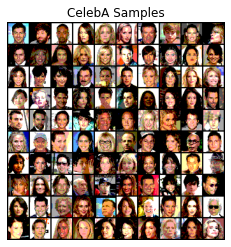

In [15]:
visualize_q1_data()

## Part (a): RealNVP


Use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.
We describe a reference architecture below that can achieve good performance, but you are free
and encouraged to use different architectures and/or structure your code differently.



```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```



Here, we provide pseudocode for the basic structure of each coupling layer. 



```
# pseudocode
ResnetBlock: n_filters
  h = x
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (3,3), stride=1, padding=1)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  return h + x

SimpleResnet: n_filters = 256, n_blocks = 8, n_out
  conv2d(in_channels, n_filters=128, (3,3), stride=1, padding=1)
  apply 8 ResnetBlocks with n_filters=128
  relu()
  conv2d(n_filters, n_filters=n_out, (3,3), stride=1, padding=1)
  
AffineCoupling(x, mask):
  x_ = x * mask
  log_s, t = torch.chunk(SimpleResnet(x_), 2, dim=1)
  # todo: calculate log_scale, as done in Q1(b)
  t = t * (1.0 - mask)
  log_scale = log_scale * (1.0 - mask)
  z = x * torch.exp(log_scale) + t
  log_det_jacobian = log_scale
  return z, log_det_jacobian
```



In [16]:
class ResnetBlock(nn.Module):
    def __init__(self, n_filters):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(n_filters, n_filters, (1, 1), stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, (1, 1), stride=1, padding=0))

    def forward(self, batch):
        return batch + self.block(batch)

In [17]:
class SimpleResnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=6, n_filters=128, n_blocks=8):
        super().__init__()
        
        layers = [nn.Conv2d(in_channels, n_filters, (3, 3), stride=1, padding=1),
                  nn.ReLU()]

        for _ in range(n_blocks):
            layers.append(ResnetBlock(n_filters))

        layers.extend(
            [nn.ReLU(),
             nn.Conv2d(n_filters, out_channels, (3, 3), stride=1, padding=1)]
        )
        
        self.model = nn.Sequential(*layers)

    def forward(self, batch):
        return self.model(batch)

In [18]:
class AffineCoupling(nn.Module):
    def __init__(self, type):
        super().__init__()
        self.mask = self.build_mask(type=type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.mlp = SimpleResnet()

    def build_mask(self, type):
        raise NotImplementedError()
        
    def forward(self, x, reverse=False):
        batch_size = x.shape[0]
        mask = self.mask.repeat(batch_size, 1, 1, 1)
        x_ = x * mask

        log_s, t = self.mlp(x_).chunk(2, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)

        if reverse:
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

In [19]:
class AffineCheckerboardTransform(AffineCoupling):
    def __init__(self, type='white'):
        super().__init__(type)

    def build_mask(self, type='white'):
        mask = np.arange(32).reshape(-1, 1) + np.arange(32)
        if type == 'white':
            mask += 1
        mask = mask.reshape(1, 1, 32, 32)
        return torch.tensor(mask % 2, dtype=torch.float32, device=device)

In [20]:
class AffineChannelTransform(AffineCoupling):
    def __init__(self, type='top'):
        super().__init__(type)
        self.resnet = SimpleResnet(in_channels=3 * 2, out_channels=3 * 4) #?

    def build_mask(self, type='top'):
        mask = torch.ones((1, 3 * 4, 16, 16), dtype=torch.float32, device=device)
        if type == 'top':
            mask[:, -3 * 2:] = 0
        elif type == 'back':
            mask[:, :3 * 2] = 0
        return mask

In [21]:
class AffineChannelTransform(nn.Module):
    def __init__(self, type='top'):
        super(AffineChannelTransform, self).__init__()
        self.type = type
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.mlp = SimpleResnet(in_channels=6, out_channels=12)

    def forward(self, x, reverse=False):
        if self.type == 'top':
            x, x_ = x.chunk(2, dim=1)
        else:
            x_, x = x.chunk(2, dim=1)

        log_s, t = self.mlp(x_).chunk(2, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift

        if reverse:
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t

        if self.type == 'top':
            return torch.cat([x, x_], dim=1), torch.cat([log_s, torch.zeros_like(log_s)], dim=1)
        else:
            return torch.cat([x_, x], dim=1), torch.cat([torch.zeros_like(log_s), log_s], dim=1)

In [22]:
class NVPTransform(nn.Module):
    def __init__(self, type='squeeze'):
        super().__init__()
        self.type = type

    @staticmethod
    def squeeze(x):
        [B, C, H, W] = x.shape
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
        return x

    @staticmethod
    def unsqueeze(x):
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
        return x

    def forward(self, x, reverse=False):
        if self.type == 'squeeze':
            if reverse:
                return self.unsqueeze(x)
            return self.squeeze(x)
        elif self.type == 'unsqueeze':
            if reverse:
                return self.squeeze(x)
            return self.unsqueeze(x)

In [23]:
class ActNorm(nn.Module):
    def __init__(self, n_channels):
        super().__init__()

        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x, reverse=False):
        if reverse:
            return (x - self.shift) * torch.exp(-self.log_scale), self.log_scale
        if not self.initialized:
            self.log_scale.data = -torch.log(torch.std(x, dim=[0, 2, 3])).reshape(1, self.n_channels, 1, 1)
            self.shift.data = -torch.mean(x, dim=[0, 2, 3], keepdim=True) * torch.exp(self.log_scale.data)
            self.initialized = True
            
        return x * torch.exp(self.log_scale) + self.shift, self.log_scale

In [24]:
class RealNVP(nn.Module):
    def __init__(self, transforms, alpha=0.05):
        super().__init__()

        self.prior = Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
        self.transforms = nn.ModuleList(transforms)
        self.alpha = alpha

    def logit_trick(self, x):
        x *= 1 - self.alpha
        x += self.alpha

        logit = torch.log(x + 1e-8) - torch.log(1 - x + 1e-8)
        log_det = torch.zeros_like(x) + F.softplus(logit) + F.softplus(-logit) + torch.tensor(1 - self.alpha, device=device).log()

        return logit, log_det

    def flow(self, x):
        z, log_det = self.logit_trick(x)
        for op in self.transforms:
            if isinstance(op, NVPTransform):
                z, log_det = op.forward(z), op.forward(log_det)
            else:
                z, delta_log_det = op.forward(z)
                log_det += delta_log_det
        return z, log_det

    def invert_flow(self, z):
        for op in reversed(self.transforms):
            if isinstance(op, NVPTransform):
                z = op.forward(z, reverse=True)
            else:
                z, _ = op.forward(z, reverse=True)
        return z

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return (self.prior.log_prob(z) + log_det).mean(dim=(1, 2, 3))

    def calculate_loss(self, x):
        return -self.log_prob(x).mean()

    @torch.no_grad()
    def test(self, test_dataloader: DataLoader) -> float:
        self.eval()

        sum_loss = 0
        n_elements = 0
        for batch in test_dataloader:
            batch_size = batch.shape[0]
            batch = batch.to(device) / 3
            loss = self.calculate_loss(batch) + torch.tensor(3, device=device).log() / (3 * 32 * 32) 
            sum_loss += batch_size * loss
            n_elements += batch_size

        self.train()
        return sum_loss.item() / n_elements

    def fit(self,
            train_dataloader: DataLoader,
            test_dataloader: DataLoader,
            epochs: int = 20,
            lr: float = 1e-3):
      
        train_losses = []
        test_losses = []

        optim = opt.Adam(self.parameters(), lr=lr)
        test_losses.append(self.test(test_dataloader))

        for epoch in trange(epochs, desc="Training"):
            for batch in train_dataloader:
                batch_size = batch.shape[0]
                batch = (batch.to(device) + torch.rand(batch.shape, device=device)) / 4.0

                loss = self.calculate_loss(batch) + torch.tensor(4, device=device).log() / (3 * 32 * 32) 

                optim.zero_grad()
                loss.backward()
                #torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                optim.step()

                train_losses.append(loss.item())
            test_losses.append(self.test(test_dataloader))
          
        return np.array(train_losses), np.array(test_losses)

    @torch.no_grad()
    def _tensor2image(self, tensor):
        tensor = 1 / (1 + torch.exp(-tensor))
        tensor -= self.alpha
        tensor /= (1 - self.alpha)
        return tensor.cpu().numpy().transpose(0, 2, 3, 1).clip(0, 1)

    @torch.no_grad()
    def sample(self, n):
        self.eval()

        z = self.prior.sample([n, 3, 32, 32])
        samples = self.invert_flow(z)

        self.train()
        return self._tensor2image(samples)

    @torch.no_grad()
    def interpolate(self, batch):
        self.eval()

        batch_size = batch.shape[0]
        batch = batch.to(device) / 3.0
        z, _ = self.flow(batch)

        latents = []
        for i in range(0, batch_size // 2):
            a = z[i].unsqueeze(0)
            b = z[batch_size // 2 + i].unsqueeze(0)

            diff = (b - a) / 5

            latents.append(a)
            for j in range(1, 5):
                latents.append(a + diff * j)
            latents.append(b)

        latents = torch.cat(latents)
        interpolations = self.invert_flow(latents)

        self.train()
        return self._tensor2image(interpolations)

We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.40 bits/dim after 100 epochs. 



**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. You should return 30 total images. 



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [25]:
class CelebDataset(Dataset):
    def __init__(self, images):
        super().__init__()

        self.images = torch.tensor(
            images.transpose(0, 3, 1, 2),
            dtype=torch.float32
        )

    def __len__(self):
        return self.images.size(0)

    def __getitem__(self, index):
        return self.images[index]

In [ ]:
def q1_a(train_data, test_data):
    """
    train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
    - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
    """

    epochs = 5
    lr = 5e-4
    batch_size = 64

    train_dataset = CelebDataset(train_data)
    test_dataset = CelebDataset(test_data)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    model = RealNVP(
        [
         AffineCheckerboardTransform('white'),
         ActNorm(3),
         AffineCheckerboardTransform('black'),
         ActNorm(3),
         AffineCheckerboardTransform('white'),
         ActNorm(3),
         AffineCheckerboardTransform('black'),
         NVPTransform('squeeze'),
         AffineChannelTransform('top'),
         ActNorm(12),
         AffineChannelTransform('back'),
         ActNorm(12),
         AffineChannelTransform('top'),
         NVPTransform('unsqueeze'),
         AffineCheckerboardTransform('white'),
         ActNorm(3),
         AffineCheckerboardTransform('black'),
         ActNorm(3),
         AffineCheckerboardTransform('white')
         ]
    ).to(device)

    train_losses, test_losses = model.fit(
        train_dataloader, test_dataloader, epochs, lr
    )

    samples = model.sample(100)

    interpolation_indexes = np.random.choice(len(test_dataset), 10, replace=False)
    interpolation_batch = test_dataset[interpolation_indexes]
    interpolations = model.interpolate(interpolation_batch)

    return train_losses, test_losses, samples, interpolations

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Training:   0%|          | 0/1 [00:00<?, ?it/s]

Final Test Loss: 21.9647


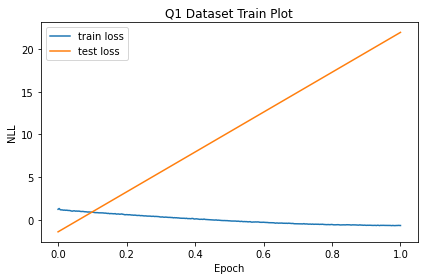

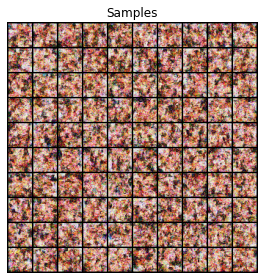

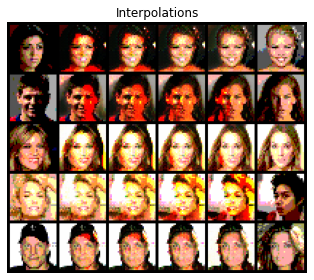

In [27]:
q1_save_results(q1_a, 'a')

In [ ]:
q1_save_results(q1_a, 'a')

## Part (b): Exploring bad masking schemes

The choice of masking or partitioning scheme affects the quality of the final flow model. In this part, design a *bad* masking scheme and train a model with it on the same CelebA dataset. 

**Provide the same deliverables as part (a)**

In [28]:
class AffineBadTransform(AffineCoupling):
    def __init__(self, type='right'):
        super().__init__(type)

    def build_mask(self, type='right'):
        mask = torch.ones((1, 1, 32, 32), dtype=torch.float32, device=device)
        if type == 'right':
            mask[:, :, :, :16] = 0
        elif type == 'left':
            mask[:, :, :, -16:] = 0

        return mask

### Solution

In [29]:
def q1_b(train_data, test_data):
    """
    train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
    - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
    """
    
    """ YOUR CODE HERE """

    epochs = 1
    lr = 5e-4
    batch_size = 64

    train_dataset = CelebDataset(train_data)
    test_dataset = CelebDataset(test_data)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    model = RealNVP(
        [
         AffineBadTransform('right'),
         ActNorm(3),
         AffineCheckerboardTransform('left'),
         ActNorm(3),
         AffineBadTransform('right'),
         ActNorm(3),
         AffineCheckerboardTransform('left'),
         ActNorm(3),
         AffineBadTransform('right'),
         ActNorm(3),
         AffineCheckerboardTransform('left'),
         ]
    ).to(device)

    train_losses, test_losses = model.fit(
        train_dataloader, test_dataloader, epochs, lr
    )

    samples = model.sample(100)

    interpolation_indexes = np.random.choice(len(test_dataset), 10, replace=False)
    interpolation_batch = test_dataset[interpolation_indexes]
    interpolations = model.interpolate(interpolation_batch)

    return train_losses, test_losses, samples, interpolations

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



In [ ]:
q1_save_results(q1_b, 'b')

Training:   0%|          | 0/1 [00:00<?, ?it/s]

## Bonus 1: Multiscale RealNVP
Following the alternating checkerboard, channel squeeze, and channel partition scheme used in https://arxiv.org/abs/1605.08803, learn a multiscale RealNVP model on our CelebA dataset used in Question 3. We expect the same deliverables as in Question 3; additionally, make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def b1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q1_save_results(b1, 'bonus1')

## Bonus 2: Glow
The Glow paper introduces the invertible 1x1 convolution as a replacement for the permutation scheme that follows the channel squeezing step. Use this in your model from Question 3, and report the same deliverables. Make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def b2(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q1_save_results(b2, 'bonus2')